In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
fig_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fig_drafts\\'

### Get the data

In [3]:
results_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fixation_period_1000ms\\'

pfdl_acf_average_trial_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfdl\\acf\\' + 'acf_average_trial_pearsonr_constrained_input_50ms_20lags_df.pkl')
pfp_acf_average_trial_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfp\\acf\\' + 'acf_average_trial_pearsonr_constrained_input_50ms_20lags_df.pkl')

pfdl_acf_average_trial_sttc_df_ = pd.read_pickle(results_folder + 'non_binned\\pfdl\\acf\\' + 'acf_average_trial_sttc_50ms_20lags_df.pkl')
pfp_acf_average_trial_sttc_df_ = pd.read_pickle(results_folder + 'non_binned\\pfp\\acf\\' + 'acf_average_trial_sttc_50ms_20lags_df.pkl')

pfdl_constrained_data_acf_binned_1000_df = pd.read_pickle(results_folder + 'pfdl_constrained_data_acf_binned_1000_df.pkl')
pfp_constrained_data_acf_binned_1000_df = pd.read_pickle(results_folder + 'pfp_constrained_data_acf_binned_1000_df.pkl')

pfdl_included_units_l = pfdl_constrained_data_acf_binned_1000_df.query('n_trials_more_20 == True and no_zero_bins == 1 and one_hz_activity == 1')['unit_id'].values
pfdl_acf_average_trial_sttc_df = pfdl_acf_average_trial_sttc_df_[pfdl_acf_average_trial_sttc_df_['unit_id'].isin(pfdl_included_units_l)].copy()
pfdl_acf_average_trial_sttc_df.reset_index(inplace=True, drop=True)

pfp_included_units_l = pfp_constrained_data_acf_binned_1000_df.query('n_trials_more_20 == True and no_zero_bins == 1 and one_hz_activity == 1')['unit_id'].values
pfp_acf_average_trial_sttc_df = pfp_acf_average_trial_sttc_df_[pfp_acf_average_trial_sttc_df_['unit_id'].isin(pfp_included_units_l)].copy()
pfp_acf_average_trial_sttc_df.reset_index(inplace=True, drop=True)

print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_acf_average_trial_pearsonr_df), len(pfp_acf_average_trial_pearsonr_df)))
print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_acf_average_trial_sttc_df), len(pfp_acf_average_trial_sttc_df)))

print('NaNs in PFdl acf {}'.format(pfdl_acf_average_trial_pearsonr_df.isnull().any().any()))
print('NaNs in PFp acf {}'.format(pfp_acf_average_trial_pearsonr_df.isnull().any().any()))

print('NaNs in PFdl acf {}'.format(pfdl_acf_average_trial_sttc_df.isnull().any().any()))
print('NaNs in PFp acf {}'.format(pfp_acf_average_trial_sttc_df.isnull().any().any()))

N neurons in PFdl 367 
N neurons in PFp 318
N neurons in PFdl 367 
N neurons in PFp 318
NaNs in PFdl acf False
NaNs in PFp acf False
NaNs in PFdl acf False
NaNs in PFp acf False


In [ ]:
pfdl_acf_average_trial_sttc_df.head(2)

In [ ]:
pfdl_tau_pearsonr_df.head(2)

In [4]:
# load taus

pfdl_tau_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfdl\\taus\\' + 'tau_acf_average_trial_pearsonr_df_constrained_input_50ms_20lags_df.pkl')
pfp_tau_pearsonr_df = pd.read_pickle(results_folder + 'binned\\pfp\\taus\\' + 'tau_acf_average_trial_pearsonr_df_constrained_input_50ms_20lags_df.pkl')

pfdl_tau_sttc_df = pd.read_pickle(results_folder + 'non_binned\\pfdl\\taus\\' + 'tau_acf_average_trial_sttc_df_constrained_input_50ms_20lags_df.pkl')
pfp_tau_sttc_df = pd.read_pickle(results_folder + 'non_binned\\pfp\\taus\\' + 'tau_acf_average_trial_sttc_df_constrained_input_50ms_20lags_df.pkl')

print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_tau_pearsonr_df), len(pfp_tau_pearsonr_df)))
print('N neurons in PFdl {} \nN neurons in PFp {}'.format(len(pfdl_tau_sttc_df), len(pfp_tau_sttc_df)))

N neurons in PFdl 367 
N neurons in PFp 318
N neurons in PFdl 367 
N neurons in PFp 318


In [5]:
pfdl_tau_acf_pearsonr_df = pfdl_acf_average_trial_pearsonr_df.merge(pfdl_tau_pearsonr_df, on='unit_id', how='left')
pfp_tau_acf_pearsonr_df = pfp_acf_average_trial_pearsonr_df.merge(pfp_tau_pearsonr_df, on='unit_id', how='left')

pfdl_tau_acf_sttc_df = pfdl_acf_average_trial_sttc_df.merge(pfdl_tau_sttc_df, on='unit_id', how='left')
pfp_tau_acf_sttc_df = pfp_acf_average_trial_sttc_df.merge(pfp_tau_sttc_df, on='unit_id', how='left')

In [ ]:
pfp_tau_acf_sttc_df.head(2)

### Calc ACF and tau constraints

1. ACF decline within 150-250ms
2. tau > 0

In [6]:
acf_cols = ['acf_' + str(i) for i in range(20)]

In [7]:
def calculate_acf_decline_flag(acf_2d, start_idx=3, end_idx=5):
    decay_l = []
    for i in range(acf_2d.shape[0]):
        decay_l.append(np.all(np.diff(acf_2d[i, start_idx:end_idx]) <= 0))
    return decay_l

In [8]:
pfdl_pearsonr_2d = pfdl_tau_acf_pearsonr_df[acf_cols].values
pfdl_pearsonr_2d_acf_decay = calculate_acf_decline_flag(pfdl_pearsonr_2d, start_idx=3, end_idx=5)

pfdl_tau_acf_pearsonr_df.insert(1, 'decline_150_250', pfdl_pearsonr_2d_acf_decay)
pfdl_tau_acf_pearsonr_df.head(2)

,unit_id,decline_150_250,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,...,acf_16,acf_17,acf_18,acf_19,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
0,0,True,1.0,0.443787,0.429808,0.374760,0.333984,0.287734,0.240484,0.189922,...,0.020760,0.038556,0.046108,-0.052432,0.744809,0.049136,-0.277458,20.351569,0.915422,1017.578448
1,3,True,1.0,0.436855,0.391458,0.371095,0.311763,0.294205,0.312247,0.282377,...,0.152333,0.194667,0.227410,0.222422,0.276401,0.164787,0.193852,6.068447,0.902445,303.422364


In [9]:
pfp_pearsonr_2d = pfp_tau_acf_pearsonr_df[acf_cols].values
pfp_pearsonr_2d_acf_decay = calculate_acf_decline_flag(pfp_pearsonr_2d, start_idx=3, end_idx=5)

pfp_tau_acf_pearsonr_df.insert(1, 'decline_150_250', pfp_pearsonr_2d_acf_decay)
pfp_tau_acf_pearsonr_df.head(2)

,unit_id,decline_150_250,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,...,acf_16,acf_17,acf_18,acf_19,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
0,0,False,1.0,0.119814,0.063838,0.059544,0.111271,0.030454,-0.016651,0.004328,...,0.046246,-0.044815,0.083069,-0.100631,0.174112,0.303765,-0.009230,3.292019,0.399825,164.600969
1,7,True,1.0,0.165524,0.143937,0.136925,0.076128,0.047678,0.020910,-0.051451,...,0.058843,-0.065524,-0.047686,-0.029775,0.264453,0.297898,-0.011497,3.356854,0.546357,167.842703


In [10]:
pfdl_sttc_2d = pfdl_tau_acf_sttc_df[acf_cols].values
pfdl_sttc_2d_acf_decay = calculate_acf_decline_flag(pfdl_sttc_2d, start_idx=3, end_idx=5)

pfdl_tau_acf_sttc_df.insert(1, 'decline_150_250', pfdl_sttc_2d_acf_decay)
pfdl_tau_acf_sttc_df.head(2)

,unit_id,decline_150_250,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,...,acf_16,acf_17,acf_18,acf_19,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
0,0,True,1.0,0.559754,0.515696,0.502268,0.482715,0.449641,0.427961,0.404055,...,0.335855,0.340939,0.316042,0.353275,0.257802,0.123009,0.320457,8.129480,0.923040,406.473977
1,3,True,1.0,0.437931,0.435684,0.405248,0.370371,0.353249,0.377837,0.349305,...,0.261334,0.313641,0.297711,0.332270,0.173394,0.148798,0.292274,6.720509,0.832371,336.025455


In [11]:
pfp_sttc_2d = pfp_tau_acf_sttc_df[acf_cols].values
pfp_sttc_2d_acf_decay = calculate_acf_decline_flag(pfp_sttc_2d, start_idx=3, end_idx=5)

pfp_tau_acf_sttc_df.insert(1, 'decline_150_250', pfp_sttc_2d_acf_decay)
pfp_tau_acf_sttc_df.head(2)

,unit_id,decline_150_250,acf_0,acf_1,acf_2,acf_3,acf_4,acf_5,acf_6,acf_7,...,acf_16,acf_17,acf_18,acf_19,fit_a,fit_b,fit_c,tau,r_squared,tau_ms
0,0,False,1.0,0.149503,0.090789,0.107328,0.142620,0.069971,0.040691,0.019864,...,0.092043,0.015594,0.023097,-0.027668,0.257802,0.123009,0.320457,8.129480,0.923040,406.473977
1,7,True,1.0,0.182435,0.124165,0.144258,0.092535,0.039624,0.032018,0.003664,...,0.198415,-0.025379,-0.018034,-0.010345,0.232486,0.209582,-0.015829,4.771405,0.664603,238.570245


In [12]:
# tau > 0
pfp_tau_acf_sttc_df['tau_more_0'] = pfp_tau_acf_sttc_df['tau_ms'] > 0
pfdl_tau_acf_sttc_df['tau_more_0'] = pfdl_tau_acf_sttc_df['tau_ms'] > 0
pfp_tau_acf_pearsonr_df['tau_more_0'] = pfp_tau_acf_pearsonr_df['tau_ms'] > 0
pfdl_tau_acf_pearsonr_df['tau_more_0'] = pfdl_tau_acf_pearsonr_df['tau_ms'] > 0

In [ ]:
pfp_tau_acf_sttc_df

In [13]:
# subsets for merging

pfdl_tau_acf_pearsonr_df_subset = pfdl_tau_acf_pearsonr_df[['unit_id', 'decline_150_250', 'tau_ms', 'r_squared', 'tau_more_0']].copy()
pfdl_tau_acf_sttc_df_subset = pfdl_tau_acf_sttc_df[['unit_id', 'decline_150_250', 'tau_ms', 'r_squared', 'tau_more_0']].copy()

pfdl_tau_acf_df_merged = pfdl_tau_acf_pearsonr_df_subset.merge(pfdl_tau_acf_sttc_df_subset, on='unit_id', how='left', suffixes=('_pear', '_sttc'))
pfdl_tau_acf_df_merged['diff'] = pfdl_tau_acf_df_merged['r_squared_sttc'] - pfdl_tau_acf_df_merged['r_squared_pear']
pfdl_tau_acf_df_merged['area'] = 'pfdl'
pfdl_tau_acf_df_merged

,unit_id,decline_150_250_pear,tau_ms_pear,r_squared_pear,tau_more_0_pear,decline_150_250_sttc,tau_ms_sttc,r_squared_sttc,tau_more_0_sttc,diff,area
0,0,True,1017.578448,0.915422,True,True,4.064740e+02,0.923040,True,0.007618,pfdl
1,3,True,303.422364,0.902445,True,True,3.360255e+02,0.832371,True,-0.070074,pfdl
2,4,True,173.862634,0.682101,True,True,2.347666e+02,0.353825,True,-0.328276,pfdl
3,5,True,441.473304,0.976189,True,True,4.800200e+02,0.977905,True,0.001716,pfdl
4,6,True,4.113527,0.001523,True,True,3.945042e+02,0.367751,True,0.366228,pfdl
...,...,...,...,...,...,...,...,...,...,...,...
362,536,True,3.958679,0.055174,True,False,3.048459e+03,0.412771,True,0.357598,pfdl
363,537,True,221.227757,0.935438,True,True,2.213418e+02,0.918267,True,-0.017172,pfdl
364,539,True,388.408834,0.454283,True,True,1.399955e+02,0.186251,True,-0.268033,pfdl
365,541,True,107.580377,0.936433,True,True,-4.056407e+06,0.507698,False,-0.428735,pfdl


In [14]:
pfp_tau_acf_pearsonr_df_subset = pfp_tau_acf_pearsonr_df[['unit_id', 'decline_150_250', 'tau_ms', 'r_squared', 'tau_more_0']].copy()
pfp_tau_acf_sttc_df_subset = pfp_tau_acf_sttc_df[['unit_id', 'decline_150_250', 'tau_ms', 'r_squared', 'tau_more_0']].copy()

pfp_tau_acf_df_merged = pfp_tau_acf_pearsonr_df_subset.merge(pfp_tau_acf_sttc_df_subset, on='unit_id', how='left', suffixes=('_pear', '_sttc'))
pfp_tau_acf_df_merged['diff'] = pfp_tau_acf_df_merged['r_squared_sttc'] - pfp_tau_acf_df_merged['r_squared_pear']
pfp_tau_acf_df_merged['area'] = 'pfp'
pfp_tau_acf_df_merged

,unit_id,decline_150_250_pear,tau_ms_pear,r_squared_pear,tau_more_0_pear,decline_150_250_sttc,tau_ms_sttc,r_squared_sttc,tau_more_0_sttc,diff,area
0,0,False,1.646010e+02,0.399825,True,False,4.064740e+02,0.923040,True,0.523215,pfp
1,7,True,1.678427e+02,0.546357,True,True,2.385702e+02,0.664603,True,0.118246,pfp
2,8,True,4.370494e+00,0.001981,True,True,1.757620e+06,0.572891,True,0.570910,pfp
3,13,True,2.752397e+02,0.786709,True,True,1.368256e+02,0.022186,True,-0.764522,pfp
4,14,True,2.111361e+02,0.231868,True,False,1.727576e+02,0.972028,True,0.740160,pfp
...,...,...,...,...,...,...,...,...,...,...,...
313,533,True,1.002737e+02,0.798517,True,True,2.503410e+03,0.381980,True,-0.416537,pfp
314,535,False,1.606635e+06,0.779183,True,False,2.306771e+02,0.162319,True,-0.616864,pfp
315,536,True,6.818200e+01,0.819945,True,True,3.048459e+03,0.412771,True,-0.407173,pfp
316,537,True,8.943022e+01,0.829613,True,True,2.213418e+02,0.918267,True,0.088653,pfp


In [16]:
tau_acf_df_merged = pd.concat([pfdl_tau_acf_df_merged, pfp_tau_acf_df_merged])
tau_acf_df_merged.reset_index(inplace=True, drop=True)
tau_acf_df_merged

,unit_id,decline_150_250_pear,tau_ms_pear,r_squared_pear,tau_more_0_pear,decline_150_250_sttc,tau_ms_sttc,r_squared_sttc,tau_more_0_sttc,diff,area
0,0,True,1.017578e+03,0.915422,True,True,406.473977,0.923040,True,0.007618,pfdl
1,3,True,3.034224e+02,0.902445,True,True,336.025455,0.832371,True,-0.070074,pfdl
2,4,True,1.738626e+02,0.682101,True,True,234.766571,0.353825,True,-0.328276,pfdl
3,5,True,4.414733e+02,0.976189,True,True,480.020044,0.977905,True,0.001716,pfdl
4,6,True,4.113527e+00,0.001523,True,True,394.504182,0.367751,True,0.366228,pfdl
...,...,...,...,...,...,...,...,...,...,...,...
680,533,True,1.002737e+02,0.798517,True,True,2503.409613,0.381980,True,-0.416537,pfp
681,535,False,1.606635e+06,0.779183,True,False,230.677079,0.162319,True,-0.616864,pfp
682,536,True,6.818200e+01,0.819945,True,True,3048.458651,0.412771,True,-0.407173,pfp
683,537,True,8.943022e+01,0.829613,True,True,221.341792,0.918267,True,0.088653,pfp


In [51]:
pfdl_tau_acf_pearsonr_df_subset_long = pfdl_tau_acf_pearsonr_df_subset.copy()
pfdl_tau_acf_pearsonr_df_subset_long['metric'] = 'pear'
pfdl_tau_acf_pearsonr_df_subset_long['area'] = 'pfdl'
pfdl_p_nan = pfdl_tau_acf_pearsonr_df_subset_long['tau_ms'].isna().sum()
print(pfdl_p_nan)

pfp_tau_acf_pearsonr_df_subset_long = pfp_tau_acf_pearsonr_df_subset.copy()
pfp_tau_acf_pearsonr_df_subset_long['metric'] = 'pear'
pfp_tau_acf_pearsonr_df_subset_long['area'] = 'pfp'
pfp_p_nan = pfp_tau_acf_pearsonr_df_subset_long['tau_ms'].isna().sum()
print(pfp_p_nan)

pfdl_tau_acf_sttc_df_subset_long = pfdl_tau_acf_sttc_df_subset.copy()
pfdl_tau_acf_sttc_df_subset_long['metric'] = 'sttc'
pfdl_tau_acf_sttc_df_subset_long['area'] = 'pfdl'
pfdl_s_nan = pfdl_tau_acf_sttc_df_subset_long['tau_ms'].isna().sum()
print(pfdl_s_nan)

pfp_tau_acf_sttc_df_subset_long = pfp_tau_acf_sttc_df_subset.copy()
pfp_tau_acf_sttc_df_subset_long['metric'] = 'sttc'
pfp_tau_acf_sttc_df_subset_long['area'] = 'pfp'
pfp_s_nan = pfp_tau_acf_sttc_df_subset_long['tau_ms'].isna().sum()
print(pfp_s_nan)

tau_df_long = pd.concat([pfdl_tau_acf_pearsonr_df_subset_long, pfp_tau_acf_pearsonr_df_subset_long, 
                         pfdl_tau_acf_sttc_df_subset_long, pfp_tau_acf_sttc_df_subset_long])
tau_df_long.reset_index(inplace=True, drop=True)
tau_df_long

1
1
0
1


,unit_id,decline_150_250,tau_ms,r_squared,tau_more_0,metric,area
0,0,True,1017.578448,0.915422,True,pear,pfdl
1,3,True,303.422364,0.902445,True,pear,pfdl
2,4,True,173.862634,0.682101,True,pear,pfdl
3,5,True,441.473304,0.976189,True,pear,pfdl
4,6,True,4.113527,0.001523,True,pear,pfdl
...,...,...,...,...,...,...,...
1365,533,True,2503.409613,0.381980,True,sttc,pfp
1366,535,False,230.677079,0.162319,True,sttc,pfp
1367,536,True,3048.458651,0.412771,True,sttc,pfp
1368,537,True,221.341792,0.918267,True,sttc,pfp


In [27]:
tau_df_long.dropna(inplace=True)
tau_df_long

,unit_id,decline_150_250,tau_ms,r_squared,tau_more_0,metric,area
0,0,True,1017.578448,0.915422,True,pear,pfdl
1,3,True,303.422364,0.902445,True,pear,pfdl
2,4,True,173.862634,0.682101,True,pear,pfdl
3,5,True,441.473304,0.976189,True,pear,pfdl
4,6,True,4.113527,0.001523,True,pear,pfdl
...,...,...,...,...,...,...,...
1365,533,True,2503.409613,0.381980,True,sttc,pfp
1366,535,False,230.677079,0.162319,True,sttc,pfp
1367,536,True,3048.458651,0.412771,True,sttc,pfp
1368,537,True,221.341792,0.918267,True,sttc,pfp


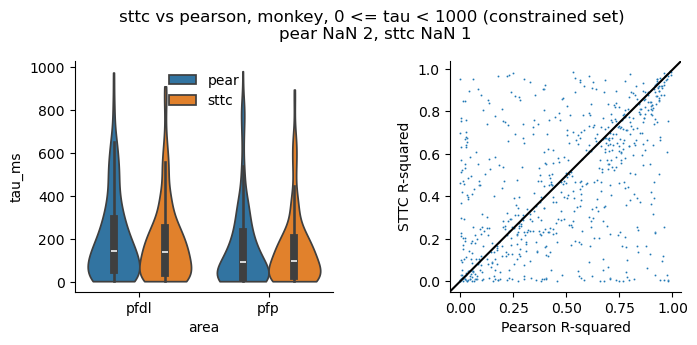

In [54]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(ax=axes[0], x='area', y='tau_ms', hue='metric', data=tau_df_long.query('tau_ms >= 0 and tau_ms < 1000'), 
               cut=0, density_norm='width')
axes[0].legend(frameon=False, loc='upper center')

sns.scatterplot(ax=axes[1], x=tau_acf_df_merged['r_squared_pear'].values, y=tau_acf_df_merged['r_squared_sttc'].values, s=2)
axes[1].plot([0, 1], [0, 1], c='k', transform=axes[1].transAxes)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel('Pearson R-squared')
axes[1].set_ylabel('STTC R-squared')
#axes[1].set_title('scatter')

# sns.histplot(ax=axes[2], x=tau_acf_df_merged['diff'].values, stat='probability', bins=100, kde=False, color='steelblue')
# axes[2].axvline(x=0, lw=1, c='k')
# axes[2].set_xlabel('STTC R-squared - \nPearson R-squared')
# axes[2].set_title('{}% STTC fits \nhave higher R-squared'.format(np.round(n_sttc_better_perc,2)))

fig.suptitle('sttc vs pearson, monkey, 0 <= tau < 1000 (constrained set) \npear NaN 2, sttc NaN 1', y=1.05)

sns.despine()

fig.savefig(fig_folder + 'sttc_vs_pearson_constrained_dataset.png' , bbox_inches='tight')

### Plots

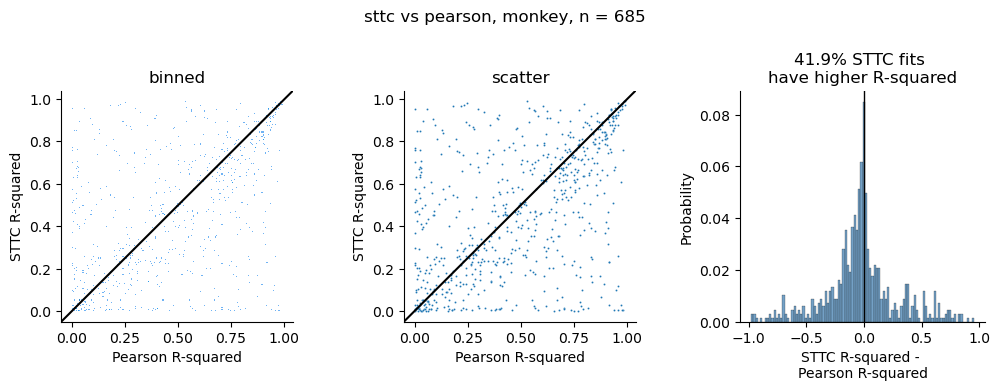

In [17]:
n_sttc_better = len(tau_acf_df_merged.query('diff > 0'))
n_sttc_better_perc = n_sttc_better / len(tau_acf_df_merged) * 100

fig, axes = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.histplot(ax=axes[0], x=tau_acf_df_merged['r_squared_pear'].values, y=tau_acf_df_merged['r_squared_sttc'].values, bins=200)
axes[0].plot([0, 1], [0, 1], c='k', transform=axes[0].transAxes)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel('Pearson R-squared')
axes[0].set_ylabel('STTC R-squared')
axes[0].set_title('binned')

sns.scatterplot(ax=axes[1], x=tau_acf_df_merged['r_squared_pear'].values, y=tau_acf_df_merged['r_squared_sttc'].values, s=2)
axes[1].plot([0, 1], [0, 1], c='k', transform=axes[1].transAxes)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel('Pearson R-squared')
axes[1].set_ylabel('STTC R-squared')
axes[1].set_title('scatter')

sns.histplot(ax=axes[2], x=tau_acf_df_merged['diff'].values, stat='probability', bins=100, kde=False, color='steelblue')
axes[2].axvline(x=0, lw=1, c='k')
axes[2].set_xlabel('STTC R-squared - \nPearson R-squared')
axes[2].set_title('{}% STTC fits \nhave higher R-squared'.format(np.round(n_sttc_better_perc,2)))

fig.suptitle('sttc vs pearson, monkey, n = ' + str(len(tau_acf_df_merged)), y=1.15)

sns.despine()

# fig.savefig(results_folder + 'pfdl_sttc_vs_pearson_50ms_20lags.png' , bbox_inches='tight')

In [ ]:
# plots taus
pfdl_tau_acf_pearsonr_df_subset.query('decline_150_250 == True and tau_more_0 == True and tau_ms <= 1000').describe()

In [ ]:
pfp_tau_acf_pearsonr_df_subset.query('decline_150_250 == True and tau_more_0 == True and tau_ms <= 1000').describe()

In [ ]:
pfdl_tau_acf_sttc_df_subset.query('decline_150_250 == True and tau_more_0 == True and tau_ms <= 1000').describe()

In [ ]:
pfp_tau_acf_sttc_df_subset.query('decline_150_250 == True and tau_more_0 == True and tau_ms <= 1000').describe()